In [3]:
!pip install torch_geometric umap-learn pacmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 45.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=550736 sha256=01bb9cfef3bbc21e54c68cd899fac88b12f1cad286eab3c2191502e96490e714
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [4]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.neighbors import kneighbors_graph
import numpy as np
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from sklearn.manifold import TSNE
import tracemalloc
import time
from umap import UMAP
from pacmap import PaCMAP
from utils import *
from metrics import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to measure GPU memory usage
def get_gpu_memory():
    return torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MB

# Load the Fashion-MNIST dataset
def load_fmnist():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
    return train_dataset

# Convert images to feature vectors
def preprocess_data(dataset):
    data = dataset.data.numpy()
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1) / 255.0
    labels = dataset.targets.numpy()
    return data, labels

def create_knn_graph_with_random_neighbor(data, k):
    # Measure start time
    start_time = time.time()

    # Start memory tracking
    tracemalloc.start()
    initial_gpu_memory = get_gpu_memory()

    knn_graph = kneighbors_graph(data, k, mode='connectivity', include_self=False)

    new_knn_graph = knn_graph

    # Measure end time
    end_time = time.time()

    # Measure memory usage
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    final_gpu_memory = get_gpu_memory()

    # Calculate and print metrics
    time_taken = end_time - start_time
    ram_used = (current - peak) / 1024 / 1024  # Convert to MB
    gpu_used = final_gpu_memory - initial_gpu_memory

    print(f"Time taken to build KNN graph: {time_taken:.2f} seconds")
    print(f"RAM used to build KNN graph: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"GPU memory used to build KNN graph: {gpu_used:.2f}MB")

    return new_knn_graph

# Convert the sparse matrix to edge_index format for PyTorch Geometric
def convert_to_torch_geometric_graph(knn_graph):
    coo = coo_matrix(knn_graph)
    edge_index = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long)
    return edge_index

# Main function to execute the steps
def get_fmnist_graph(n_samples=35000):
    # Load and preprocess the data
    train_dataset = load_fmnist()
    x_train, y_train = preprocess_data(train_dataset)

    # Use a subset of the data for simplicity (e.g., first 1000 samples)
    x_subset = x_train[:n_samples]
    y_subset = y_train[:n_samples]

    # Create KNN graph
    k = 4  # Number of neighbors
    knn_graph = create_knn_graph_with_random_neighbor(x_subset, k)

    # Convert to PyTorch Geometric Data object
    edge_index = convert_to_torch_geometric_graph(knn_graph)
    x = torch.tensor(x_subset, dtype=torch.float)
    y = torch.tensor(y_subset, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)

    # Set additional attributes for compatibility
    data.num_node_features = data.x.shape[1]
    data.num_classes = len(torch.unique(data.y))
    data.num_features = data.num_node_features

    # Print the Data object to verify
    print(data)
    print(f"Number of node features: {data.num_node_features}")
    print(f"Number of classes: {data.num_classes}")
    print(f"Number of features: {data.num_features}")

    generate_train_test(data)

    return data

In [ ]:
data = get_fmnist_graph(25000)

X = data.x.numpy()

local_metrics = LocalMetric()

Time taken to build KNN graph: 37.85 seconds
RAM used to build KNN graph: Current=521.72MB, Peak=522.67MB
GPU memory used to build KNN graph: 0.00MB
Data(x=[25000, 784], edge_index=[2, 100000], y=[25000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [ ]:
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class ResidualGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        # Residual connection from input to output
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        if x.size(-1) != identity.size(-1):
            identity = self.shortcut(identity)

        x = self.conv3(x, edge_index)

        x += identity  # Add the input to the output
        return x


class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels_AE = 2
num_features = data.num_features
num_classes = data.num_classes
epochs_AE = 200
hidden_channels_AE = 16

# Model initialization
model = GAE(ResidualGCNEncoder(num_features, hidden_channels_AE, out_channels_AE)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

GAE_loss_history = []

# Training the GAE model with metrics measurement
print("Training GAE model...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

for epoch in range(1, epochs_AE + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    GAE_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"GAE Training Time: {time_taken:.2f} seconds")
print(f"GAE Training RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"GAE Training GPU Memory usage: {gpu_used:.2f}MB")


# Update data.x with the encoded features for classification
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()
data.x = encoded_features
hidden_channels_GNN = 16

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels_AE, hidden_channels_GNN, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

GNN_loss_history = []

# Training the GNN model
for epoch in range(300):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    GNN_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Training GAE model...
Epoch: 10, Loss: 1.808842420578003
Epoch: 20, Loss: 1.4034749269485474
Epoch: 30, Loss: 1.2841325998306274
Epoch: 40, Loss: 1.210627794265747
Epoch: 50, Loss: 1.1884491443634033
Epoch: 60, Loss: 1.1006768941879272
Epoch: 70, Loss: 1.0932875871658325
Epoch: 80, Loss: 1.0846997499465942
Epoch: 90, Loss: 1.073552131652832
Epoch: 100, Loss: 1.067566156387329
Epoch: 110, Loss: 1.0657392740249634
Epoch: 120, Loss: 1.0604984760284424
Epoch: 130, Loss: 1.060120940208435
Epoch: 140, Loss: 1.057566523551941
Epoch: 150, Loss: 1.0571377277374268
Epoch: 160, Loss: 1.054636001586914
Epoch: 170, Loss: 1.048520803451538
Epoch: 180, Loss: 1.0547847747802734
Epoch: 190, Loss: 1.0522444248199463
Epoch: 200, Loss: 1.0460139513015747
GAE Training Time: 99.05 seconds
GAE Training RAM Memory usage: Current=0.12MB, Peak=11.34MB
GAE Training GPU Memory usage: -2.34MB
Epoch 0, Loss: 2.307107925415039
Epoch 10, Loss: 2.028437852859497
Epoch 20, Loss: 1.7748583555221558
Epoch 30, Loss: 1.579

In [ ]:
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    preds = out.argmax(dim=1)
    labels = data.y
    mask = data.test_mask
    test_preds = preds[mask].cpu().numpy()
    test_labels = labels[mask].cpu().numpy()

    accuracy = accuracy_score(test_labels, test_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')

print(f"GNN accuracy: {accuracy:.4f}, GNN precision: {precision:.4f}, GNN recall: {recall:.4f}, GNN F1 score: {f1:.4f}")

GNN accuracy: 0.5326, GNN precision: 0.5051, GNN recall: 0.5269, GNN F1 score: 0.4767


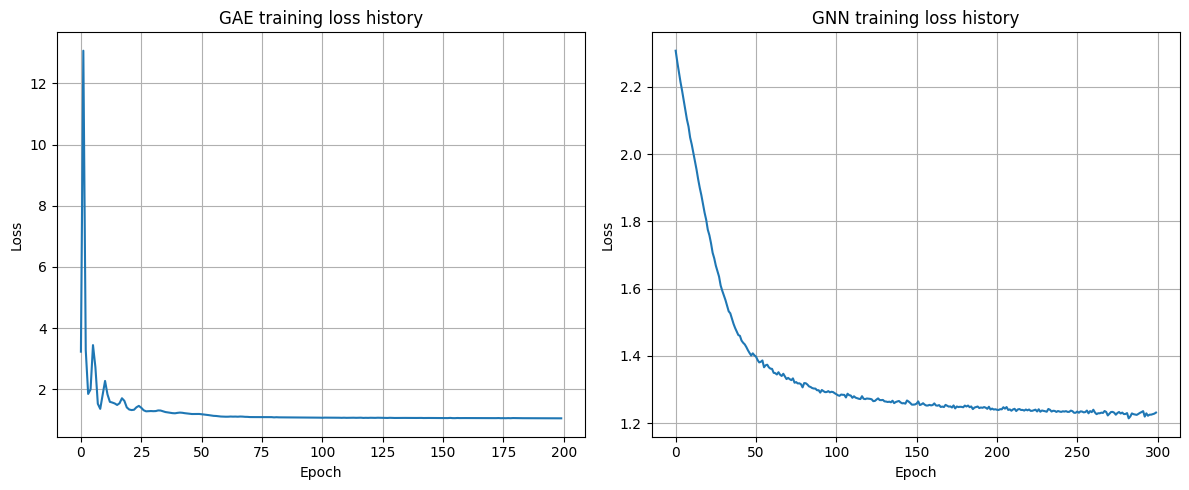

In [ ]:
plt.figure(figsize=(12, 5))

# GAE training loss history
plt.subplot(1, 2, 1)
plt.plot(GAE_loss_history, label='GAE training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAE training loss history')
plt.grid(True)  # Assuming you want to always display the grid


# GNN training loss history
plt.subplot(1, 2, 2)
plt.plot(GNN_loss_history, label='GNN training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GNN training loss history')
plt.grid(True)  # Assuming you want to always display the grid


plt.tight_layout()
plt.show()

Time taken to build KNN graph: 26.01 seconds
RAM used to build KNN graph: Current=1.28MB, Peak=2.24MB
GPU memory used to build KNN graph: 0.00MB
Data(x=[25000, 784], edge_index=[2, 100000], y=[25000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784
Calculating d_hd
fMNIST GAE-residual


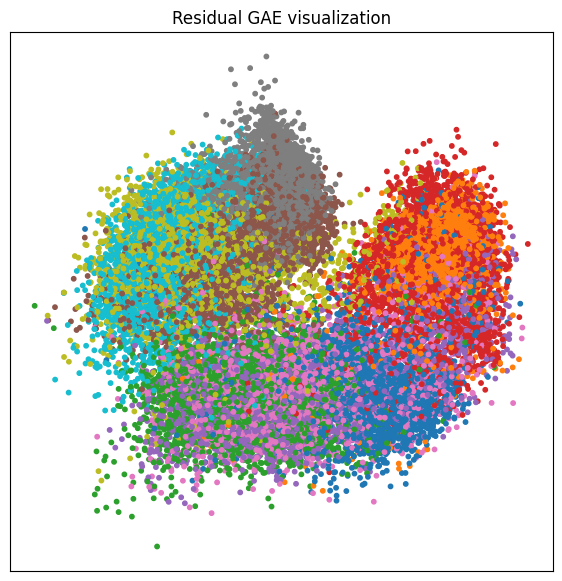

In [ ]:
pure_data = get_fmnist_graph(25000)
pure_X = pure_data.x.cpu().detach().numpy()
pure_labels = pure_data.y.cpu().numpy()

GAE_variant = "residual"
dataset_name = "fMNIST"
algorithm_name = "GAE"
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features.cpu().detach().numpy(),
    X_hds=pure_X,
    labels=pure_labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

fig, ax = plt.subplots(figsize=(7, 7))
plot_no_show(ax, encoded_features.cpu().detach().numpy(), pure_labels, 'Residual GAE visualization', size=10, sample=False)
plt.show()


# 2. Residual GAE + tSNE

Time taken to build KNN graph: 25.79 seconds
RAM used to build KNN graph: Current=1.27MB, Peak=2.23MB
GPU memory used to build KNN graph: 0.00MB
Data(x=[25000, 784], edge_index=[2, 100000], y=[25000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Training GAE model...
Epoch: 10, Loss: 1.1516001224517822
Epoch: 20, Loss: 1.04818594455719
Epoch: 30, Loss: 1.0004740953445435
Epoch: 40, Loss: 0.9710478186607361
Epoch: 50, Loss: 0.9522498250007629
Epoch: 60, Loss: 0.9374240040779114
Epoch: 70, Loss: 0.9337046146392822
Epoch: 80, Loss: 0.9240278005599976
Epoch: 90, Loss: 0.9158690571784973
Epoch: 100, Loss: 0.9077599048614502
Epoch: 110, Loss: 0.9028494358062744
Epoch: 120, Loss: 0.8938456177711487
Epoch: 130, Loss: 0.8872217535972595
Epoch: 140, Loss: 0.8812665343284607
Epoch: 150, Loss: 0.8753939270973206
Epoch: 160, Loss: 0.8736140131950378
Epoch: 170, Loss: 0.866305947303772
Epoch: 180, Loss: 0.8636618256568909
Epoch: 190, Loss: 0.8583348393440247
Epoch: 200, Loss: 0.8566670417785645
GAE Training Time: 92.15 seconds
GAE Training RAM Memory usage: Current=0.10MB, Peak=11.31MB
GAE Training GPU Memory usage: 2.13MB
Epoch 0, Loss: 2.3335578441619873
Epoch 10, Loss: 1.9446312189102173
Epoch 20, Loss: 1.6075561046600342
Epoch 30, Loss:

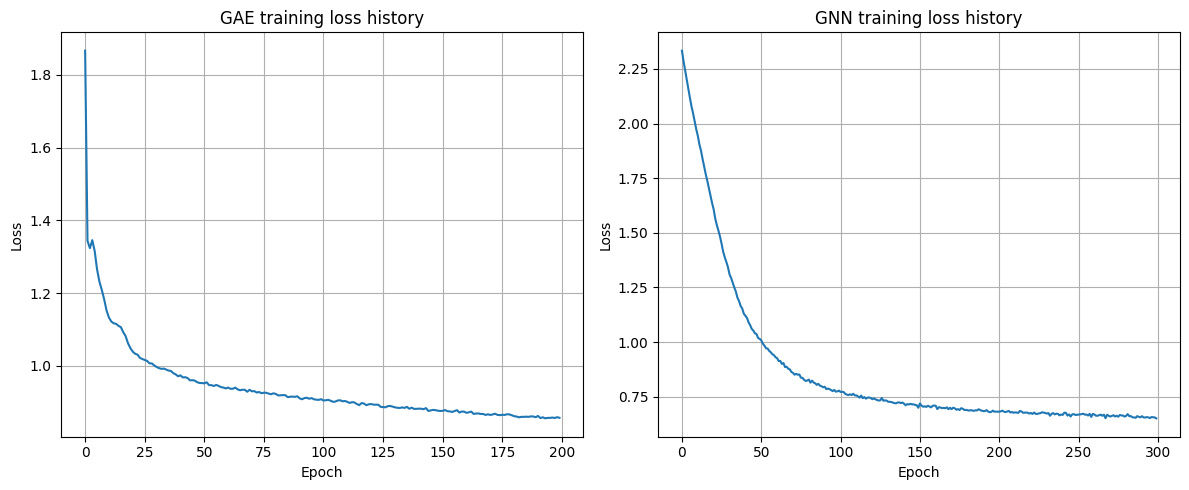

Calculating d_hd
fMNIST GAE-residual + t-SNE


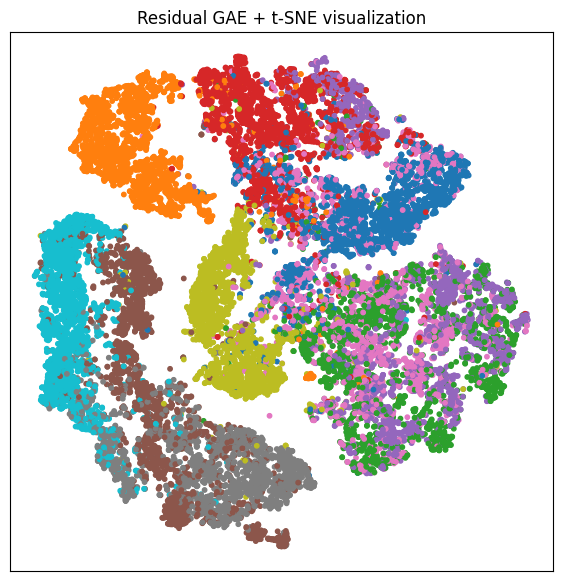

In [ ]:
data = get_fmnist_graph(25000)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges

data = train_test_split_edges(data)

# Parameters
out_channels_AE = 16
num_features = data.num_features
num_classes = data.num_classes
epochs_AE = 200
hidden_channels_AE = 32

# Model initialization
model = GAE(ResidualGCNEncoder(num_features, hidden_channels_AE, out_channels_AE)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

GAE_loss_history = []

# Training the GAE model with metrics measurement
print("Training GAE model...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

for epoch in range(1, epochs_AE + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    GAE_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"GAE Training Time: {time_taken:.2f} seconds")
print(f"GAE Training RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"GAE Training GPU Memory usage: {gpu_used:.2f}MB")

# Update data.x with the encoded features for classification
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()
data.x = encoded_features
hidden_channels_GNN = 16

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels_AE, hidden_channels_GNN, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

GNN_loss_history = []

# Training the GNN model
for epoch in range(300):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    GNN_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    preds = out.argmax(dim=1)
    labels = data.y
    mask = data.test_mask
    test_preds = preds[mask].cpu().numpy()
    test_labels = labels[mask].cpu().numpy()

    accuracy = accuracy_score(test_labels, test_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')

print(f"GNN accuracy: {accuracy:.4f}, GNN precision: {precision:.4f}, GNN recall: {recall:.4f}, GNN F1 score: {f1:.4f}")

tsne = TSNE(n_components=2, random_state=0)

# Perform t-SNE transformation with metrics measurement
print("Performing t-SNE transformation...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

tsne_results = tsne.fit_transform(encoded_features.cpu().detach().numpy())

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"t-SNE Transformation Time: {time_taken:.2f} seconds")
print(f"t-SNE Transformation RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"t-SNE Transformation GPU Memory usage: {gpu_used:.2f}MB")
plt.figure(figsize=(12, 5))

# GAE training loss history
plt.subplot(1, 2, 1)
plt.plot(GAE_loss_history, label='GAE training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAE training loss history')
plt.grid(True)  # Assuming you want to always display the grid


# GNN training loss history
plt.subplot(1, 2, 2)
plt.plot(GNN_loss_history, label='GNN training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GNN training loss history')
plt.grid(True)  # Assuming you want to always display the grid


plt.tight_layout()
plt.show()

pure_labels = pure_data.y.cpu().numpy()

GAE_variant = "residual + t-SNE"
dataset_name = "fMNIST"
algorithm_name = "GAE"
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=pure_X,
    labels=pure_labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))



fig, ax = plt.subplots(figsize=(7, 7))
plot_no_show(ax, tsne_results, pure_labels, 'Residual GAE + t-SNE visualization', size=10, sample=False)
plt.show()

# 3. pure t-SNE

Performing t-SNE transformation...
t-SNE Transformation Time: 366.25 seconds
t-SNE Transformation RAM Memory usage: Current=0.28MB, Peak=157.73MB
t-SNE Transformation GPU Memory usage: 0.00MB
Calculating d_hd
fMNIST t-SNE


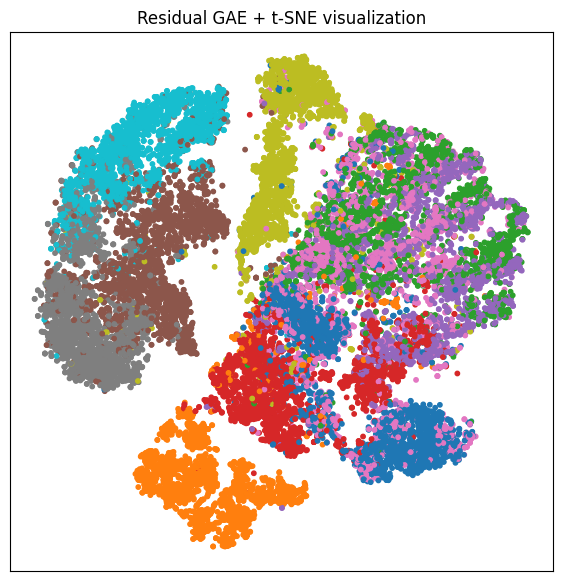

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
# Perform t-SNE transformation with metrics measurement
print("Performing t-SNE transformation...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

tsne_results = tsne.fit_transform(pure_X)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"t-SNE Transformation Time: {time_taken:.2f} seconds")
print(f"t-SNE Transformation RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"t-SNE Transformation GPU Memory usage: {gpu_used:.2f}MB")


GAE_variant = "t-SNE"
dataset_name = "fMNIST"
algorithm_name = ""
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=pure_X,
    labels=pure_labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}{GAE_variant}"))

fig, ax = plt.subplots(figsize=(7, 7))
plot_no_show(ax, tsne_results, pure_labels, 'Residual GAE + t-SNE visualization', size=10, sample=False)
plt.show()

Finished.


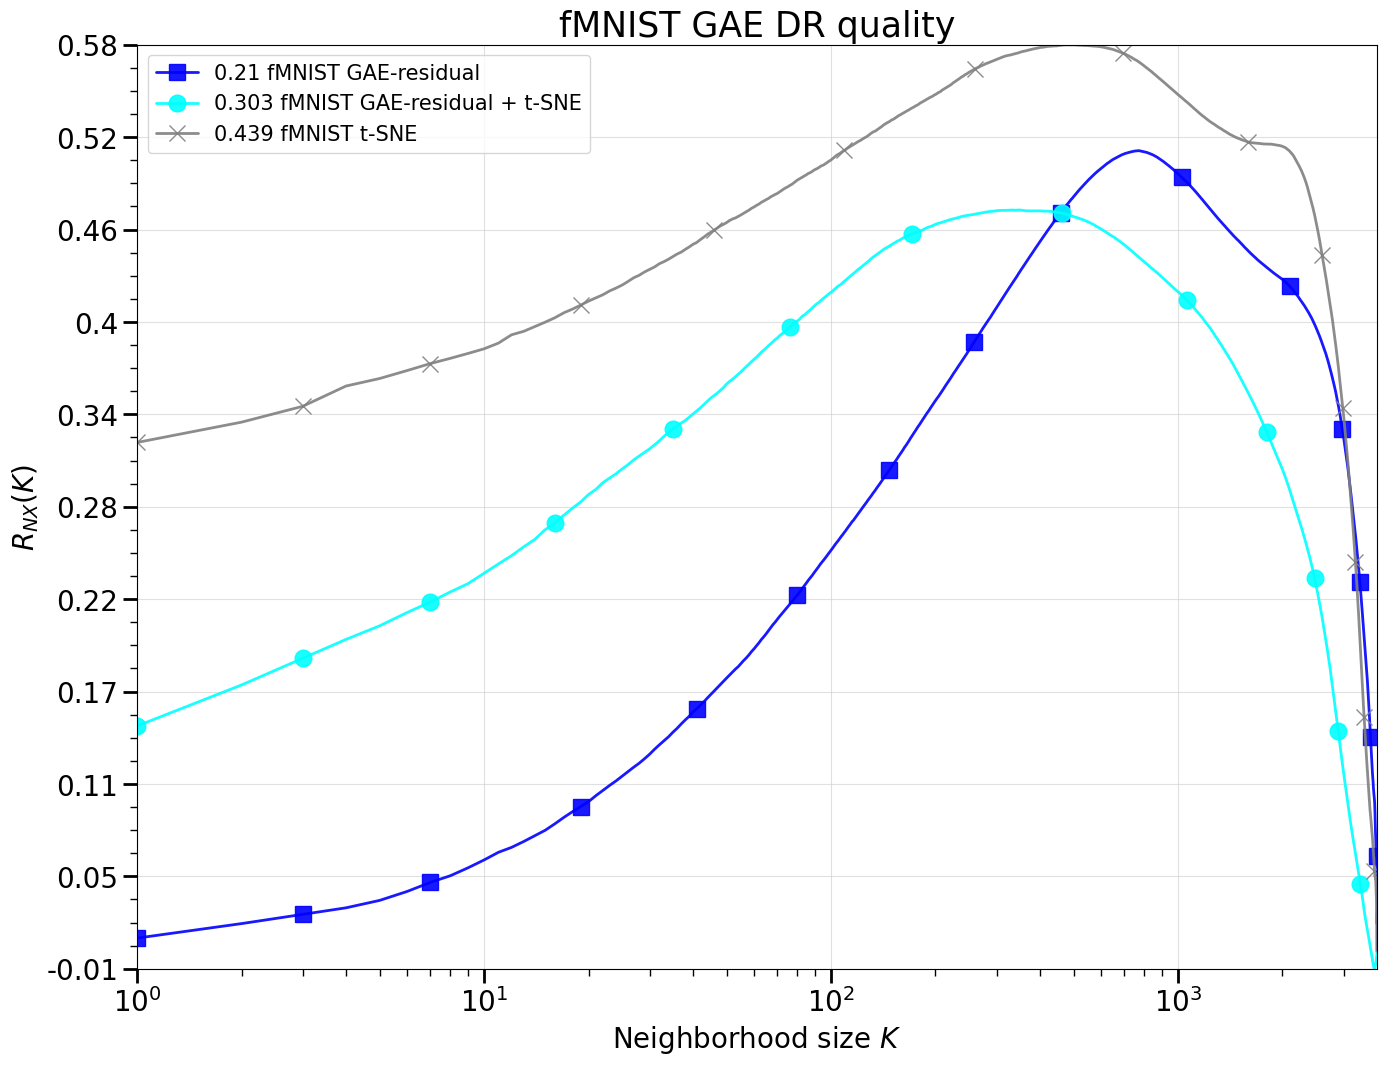

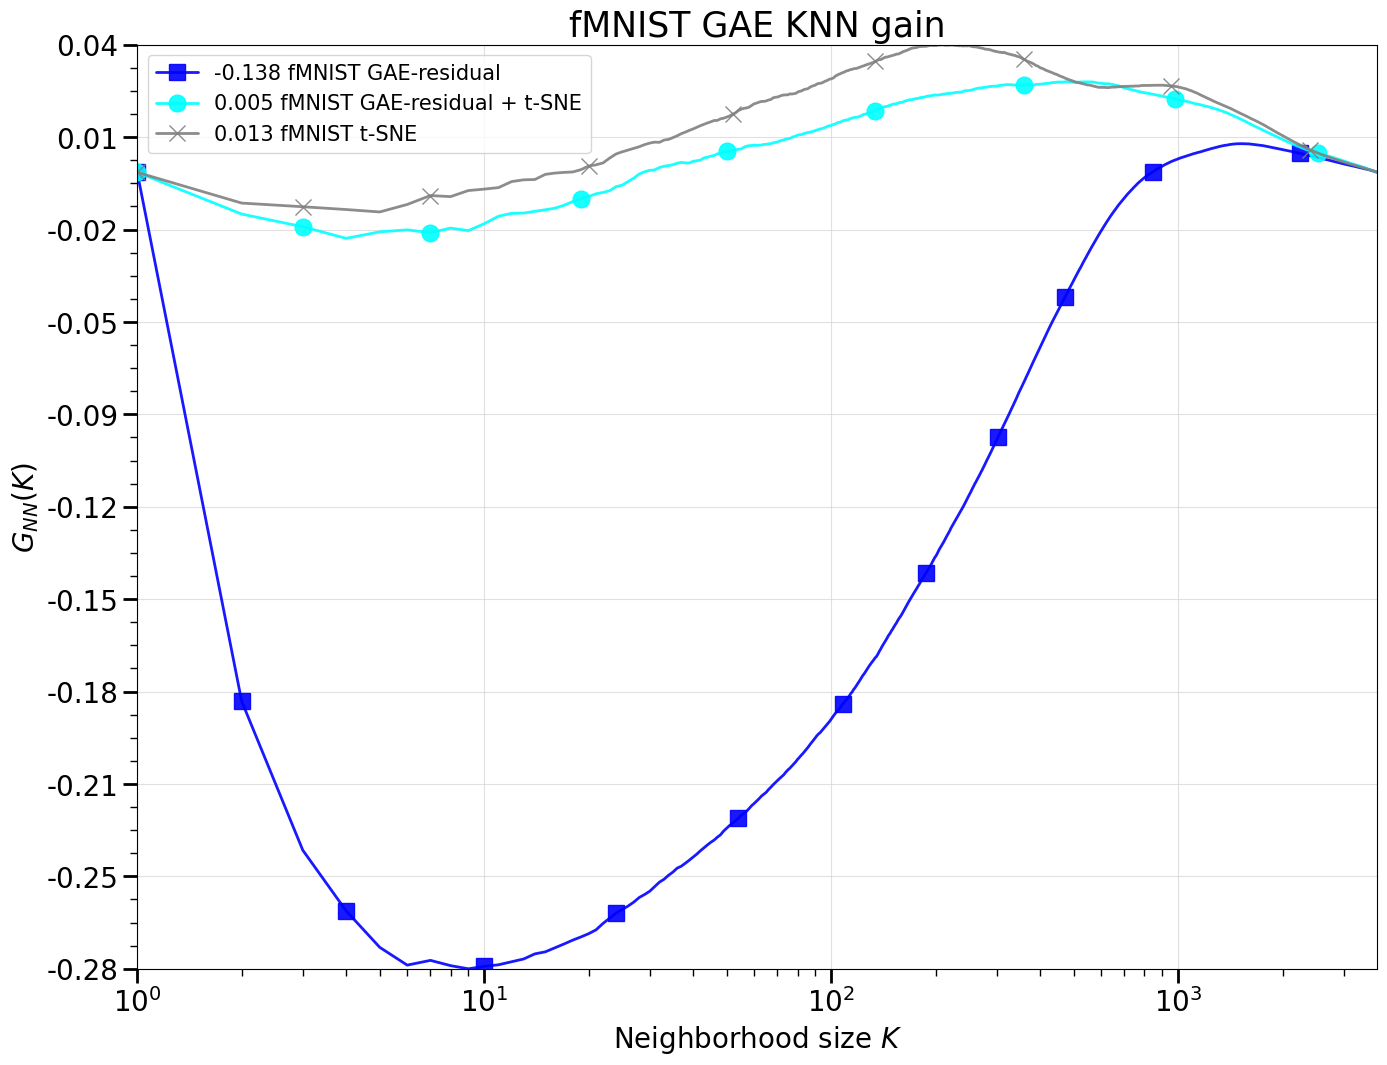

In [ ]:
local_metrics.visualize(f"fMNIST GAE")

# 4. Residual GAE + UMAP & PacMAP

In [6]:
data = get_fmnist_graph(25000)

X = data.x.numpy()

data = get_fmnist_graph(25000)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges

data = train_test_split_edges(data)

# Parameters
out_channels_AE = 16
num_features = data.num_features
num_classes = data.num_classes
epochs_AE = 200
hidden_channels_AE = 32


class ResidualGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        # Residual connection from input to output
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        if x.size(-1) != identity.size(-1):
            identity = self.shortcut(identity)

        x = self.conv3(x, edge_index)

        x += identity  # Add the input to the output
        return x


# Model initialization
model = GAE(ResidualGCNEncoder(num_features, hidden_channels_AE, out_channels_AE)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

GAE_loss_history = []

# Training the GAE model with metrics measurement
print("Training GAE model...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

for epoch in range(1, epochs_AE + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    GAE_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory


# Update data.x with the encoded features for classification
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()
data.x = encoded_features





Time taken to build KNN graph: 29.59 seconds
RAM used to build KNN graph: Current=1.28MB, Peak=2.23MB
GPU memory used to build KNN graph: 0.00MB
Data(x=[25000, 784], edge_index=[2, 100000], y=[25000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784
Time taken to build KNN graph: 24.98 seconds
RAM used to build KNN graph: Current=1.27MB, Peak=2.23MB
GPU memory used to build KNN graph: 0.00MB
Data(x=[25000, 784], edge_index=[2, 100000], y=[25000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Training GAE model...
Epoch: 10, Loss: 1.1715893745422363
Epoch: 20, Loss: 1.0995383262634277
Epoch: 30, Loss: 1.0206389427185059
Epoch: 40, Loss: 0.9719429016113281
Epoch: 50, Loss: 0.9547231793403625
Epoch: 60, Loss: 0.9410078525543213
Epoch: 70, Loss: 0.9321216344833374
Epoch: 80, Loss: 0.9201062917709351
Epoch: 90, Loss: 0.9171617031097412
Epoch: 100, Loss: 0.9099062085151672
Epoch: 110, Loss: 0.9062817096710205
Epoch: 120, Loss: 0.9042856693267822
Epoch: 130, Loss: 0.9003888368606567
Epoch: 140, Loss: 0.8952349424362183
Epoch: 150, Loss: 0.8927078247070312
Epoch: 160, Loss: 0.8882825970649719
Epoch: 170, Loss: 0.8853146433830261
Epoch: 180, Loss: 0.8830334544181824
Epoch: 190, Loss: 0.876402735710144
Epoch: 200, Loss: 0.8723533153533936
Performing UMAP transformation...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


NameError: name 'pure_data' is not defined

Time taken to build KNN graph: 27.57 seconds
RAM used to build KNN graph: Current=1.27MB, Peak=2.23MB
GPU memory used to build KNN graph: 0.00MB
Data(x=[25000, 784], edge_index=[2, 100000], y=[25000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784
Performing UMAP transformation...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


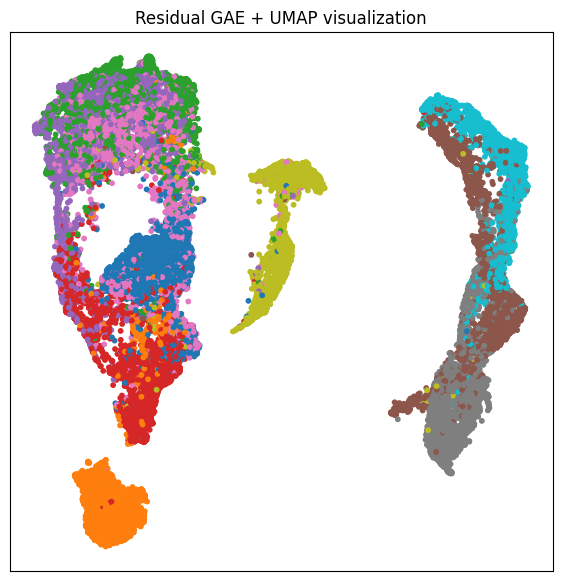

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:828: UserWarning: Warning: random state is set to 0
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


Performing PaCMAP transformation...


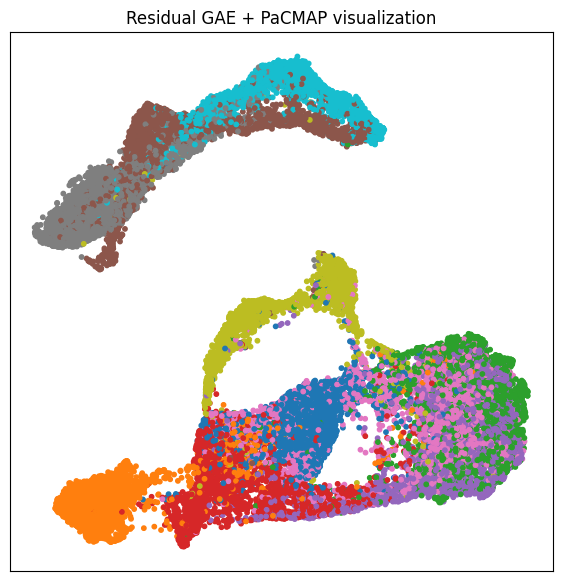

In [7]:
pure_data = get_fmnist_graph(25000)
pure_X = pure_data.x.cpu().detach().numpy()
pure_labels = pure_data.y.cpu().numpy()

umap = UMAP(n_components=2, random_state=0)

print("Performing UMAP transformation...")

umap_results = umap.fit_transform(encoded_features.cpu().detach().numpy())


pure_labels = pure_data.y.cpu().numpy()


fig, ax = plt.subplots(figsize=(7, 7))
plot_no_show(ax, umap_results, pure_labels, 'Residual GAE + UMAP visualization', size=10, sample=False)
plt.show()

pacmap = PaCMAP(n_components=2, random_state=0)

print("Performing PaCMAP transformation...")

pacmap_results = pacmap.fit_transform(encoded_features.cpu().detach().numpy())



fig, ax = plt.subplots(figsize=(7, 7))
plot_no_show(ax, pacmap_results, pure_labels, 'Residual GAE + PaCMAP visualization', size=10, sample=False)
plt.show()
